In [16]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, use_plots, log_plots

from tqdm import tqdm
import os

import seaborn as sns
sns.set_theme(style="whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
experiment = "ml-1m"
dataset_dir = use_dataset(experiment)
result_dir = use_results(experiment, download=False)

/data/wooders/ralf-vldb//datasets/ml-1m


# Runtime Analysis 

In [ ]:
lines = open(f"{result_dir}/runtimes.txt").read().split("\n")
runtimes = pd.DataFrame({"runtimes": [float(l) for l in lines[:-1]]})

In [ ]:
plt.tight_layout()

f, ax = plt.subplots(ncols=1, figsize=(10, 5))
   
sns.boxplot(x=runtimes["runtimes"])
ax.set(title="Featurization Runtime (Recommendation)", xlabel="Time (s)")
 

In [ ]:
avg_runtime = runtimes.runtimes.mean()
avg_runtime

In [40]:
split = 0.75 
#updates_per_ts = [0.5, 0.25, 0.2, 1, 2, 3, 4, 5, 8, 10000, None]
updates_per_ts = [0.5, 0.25, 0.2, 1, 2, 3, 4, 5, 8]
ts_factor = [60] #, 60*60, 60*60*24]
policies = ["random", "total_error_cold", "query_proportional", "max_pending", "min_past", "round_robin", "batch"] #, "last_query"]

In [64]:
limit = 100000 #100000

In [65]:
stream_df = pd.read_csv(f'{dataset_dir}/stream_{split}.csv')
start_ts = stream_df.timestamp.min()
stream_df.timestamp = stream_df.timestamp.apply(lambda ts: ts - start_ts)
stream_df

,user_id,movie_id,rating,timestamp
0,1,661,3,3081168
1,1,914,3,3081027
2,1,3408,4,3079334
3,1,2355,5,3603350
4,1,1197,3,3081327
...,...,...,...,...
249907,6040,1333,4,22233199
249908,6040,3362,4,22232855
249909,6040,161,3,22233545
249910,6040,2725,4,22233239


# Collect Baselines 

In [66]:
results = []

for baseline in [None, 10000]:
    for t in ts_factor: 

        update_df = pd.read_csv(f"{result_dir}/round_robin_{baseline}_{t}_split_{split}_updates.csv")
        df = pd.read_csv(f"{result_dir}/round_robin_{baseline}_{t}_split_{split}_results.csv")
        print(len(df.index))
        df = df.iloc[:limit]
        
        timestamp = df.timestamp.max()
        update_df = update_df[update_df["time"] < timestamp]

        error = mean_squared_error(df.y_pred, df.y_true)
        total_updates = len(update_df.index)

        if baseline is None:
            results.append([0, error, total_updates, t, df.timestamp.max()])
        else: 
            results.append([baseline, error, total_updates, t, df.timestamp.max()])
        
baseline_results_df = pd.DataFrame(results, columns=["updates", "error", "total_updates", "ts_factor", "max_ts"])
baseline_results_df

249912
249912


,updates,error,total_updates,ts_factor,max_ts
0,0,6.294494,0,60,20018
1,10000,1.116946,25497,60,20018


In [67]:
updates_df = pd.DataFrame()
df_all = pd.DataFrame()
results = [] 

for p in policies: 
    for u in updates_per_ts: 
        for t in ts_factor: 
            
            if not os.path.exists(f"{result_dir}/{p}_{u}_{t}_split_{split}_updates.csv"): 
                continue
                
            update_df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_split_{split}_updates.csv")
            df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_split_{split}_results.csv")
            
            
            if limit is not None:
                if len(df.index) <= limit: 
                    print(f"{result_dir}/{p}_{u}_{t}_split_{split}_results.csv")
                    continue 

                # filter time 
                df = df.iloc[:limit]
                timestamp = df.timestamp.max()
                update_df = update_df[update_df["time"] < timestamp]

            print(p, u, t, df.timestamp.max(), update_df["time"].max())
            
            df["policy"] = p
            df["updates"] = u 
            df["ts_factor"] = t
            update_df["updates"] = u 
            update_df["ts_factor"] = t
            
            # threshold predictions 
            df["y_pred"][df["y_pred"] > 5] = 5
            df["y_pred"][df["y_pred"] < 1] = 1
            
            #print(df.y_pred)
            #print(df.y_true)

            error = mean_squared_error(df.y_pred, df.y_true)
            
            #print(update_df.time.value_counts())
            

            total_updates = len(update_df.index)
            print(total_updates, len(df.index), error)
            results.append([u , p, error, total_updates, t, df.timestamp.max()])
            updates_df = pd.concat([updates_df, update_df])
            df_all = pd.concat([df_all, df])
      
results_df = pd.DataFrame(results, columns=["updates", "policy", "error", "total_updates", "ts_factor", "max_ts"])
results_df

random 0.5 60 20018 20017
6379 100000 1.9776054284791853
random 0.25 60 20018 20016
3368 100000 3.1720958251822107


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value

random 0.2 60 20018 20016
2754 100000 3.5523055934355394


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


random 1 60 20018 20017
12069 100000 1.4381579039372605
random 2 60 20018 20017


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value

19004 100000 1.2083834168442427
random 3 60 20018 20017
22537 100000 1.142413911230998


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value

random 4 60 20018 20017
24224 100000 1.1242251931004223
random 5 60 20018 20017


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5


24999 100000 1.11937675136442
random 8 60 20018 20017
25489 100000 1.116945873994004


/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 0.5 60 20018 20017
6379 100000 1.1926222202625603
total_error_cold 0.25 60 20018 20016


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1
/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value

3368 100000 1.381798818690464
total_error_cold 0.2 60 20018 20016
2754 100000 1.4629017286642394
total_error_cold 1 60 20018 20017
12069 100000 1.1284454216103446


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 2 60 20018 20017
19214 100000 1.1198552883806425


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 3 60 20018 20017
22664 100000 1.1178824118243553


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 4 60 20018 20017
24275 100000 1.1175687025598082


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 5 60 20018 20017
25029 100000 1.117281807074001


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 8 60 20018 20017
25490 100000 1.1169458572953137


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.5 60 20018 20017
6379 100000 1.852802607569744


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.25 60 20018 20016
3368 100000 2.503440698433231


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.2 60 20018 20016
2754 100000 2.800305617111734


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 1 60 20018 20017
12069 100000 1.4273767205506747


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 2 60 20018 20017
19244 100000 1.192327137000598


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 3 60 20018 20017
22719 100000 1.138525148458255


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 4 60 20018 20017
24309 100000 1.1235843689234475


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 5 60 20018 20017
25039 100000 1.1185107321870342


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 8 60 20018 20017
25494 100000 1.1169458736716757


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.5 60 20018 20017
6379 100000 1.852802607569744


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.25 60 20018 20016
3368 100000 2.503440698433231


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.2 60 20018 20016
2754 100000 2.800305617111734


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 1 60 20018 20017
12069 100000 1.4273767205506747


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 2 60 20018 20017
19244 100000 1.192327137000598


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 3 60 20018 20017
22719 100000 1.138525148458255


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 4 60 20018 20017
24309 100000 1.1235843689234475


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 5 60 20018 20017
25039 100000 1.1185107321870342


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 8 60 20018 20017
25494 100000 1.1169458736716757


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.5 60 20018 20017
6379 100000 1.217356150505529


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.25 60 20018 20016
3368 100000 1.4212055257294396


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.2 60 20018 20016
2754 100000 1.5035500630157361


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 1 60 20018 20017
12069 100000 1.152805743614331


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 2 60 20018 20017
19164 100000 1.1250947612724227


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 3 60 20018 20017
22629 100000 1.1184296644979703


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 4 60 20018 20017
24269 100000 1.117483935665935


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 5 60 20018 20017
25007 100000 1.1169576797773746


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 8 60 20018 20017
25491 100000 1.1169459020082333


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.5 60 20018 20017
6379 100000 1.374474554947482


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.25 60 20018 20016
3368 100000 1.8209128459395336


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.2 60 20018 20016
2754 100000 1.991348032182873


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 1 60 20018 20017
12069 100000 1.16117466638174


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 2 60 20018 20017
19225 100000 1.117061618101543


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 3 60 20018 20017
22649 100000 1.1170316516820955


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 4 60 20018 20017
24284 100000 1.116930024219317


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 5 60 20018 20017
25019 100000 1.1169474491093438


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 8 60 20018 20017
25489 100000 1.1169458696008576


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 0.5 60 20018 20016
6034 100000 1.9218192808123697


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 0.25 60 20018 20008
3015 100000 3.393459502150832


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 0.2 60 20018 20009
2387 100000 3.977835115233654


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 1 60 20018 20016
12068 100000 1.364883696937029


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 2 60 20018 20016
17940 100000 1.1838865621916277


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 3 60 20018 20017
21290 100000 1.1454034182671686


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 4 60 20018 20017
23287 100000 1.1311883948580133


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 5 60 20018 20017
24373 100000 1.12362470393528


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 8 60 20018 20017
25448 100000 1.116839560941109


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


,updates,policy,error,total_updates,ts_factor,max_ts
0,0.50,random,1.977605,6379,60,20018
1,0.25,random,3.172096,3368,60,20018
2,0.20,random,3.552306,2754,60,20018
3,1.00,random,1.438158,12069,60,20018
4,2.00,random,1.208383,19004,60,20018
...,...,...,...,...,...,...
58,2.00,batch,1.183887,17940,60,20018
59,3.00,batch,1.145403,21290,60,20018
60,4.00,batch,1.131188,23287,60,20018
61,5.00,batch,1.123625,24373,60,20018


In [63]:
plots_dir = use_plots("ml-1m")
results_df.to_csv(f"{plots_dir}/results.csv")
baseline_results_df.to_csv(f"{plots_dir}/baseline.csv")
updates_df.to_csv(f"{plots_dir}/updates.csv")
log_plots("ml-1m")

{'results_dir': '/data/wooders/ralf-vldb//results', 'dataset_dir': '/data/wooders/ralf-vldb//datasets', 'plots_dir': '/data/wooders/ralf-vldb//plots', 'aws_dir': 'vldb', 'credentials': '/home/eecs/wooders/experiments/ralf-vldb.json'}
uploading /data/wooders/ralf-vldb//plots ml-1m
vldb/plots ml-1m /ml-1m/baseline.csv
uploading /data/wooders/ralf-vldb//plots/ml-1m vldb/plots vldb/plots/ml-1m/baseline.csv
vldb/plots ml-1m /ml-1m/updates.csv
uploading /data/wooders/ralf-vldb//plots/ml-1m vldb/plots vldb/plots/ml-1m/updates.csv
vldb/plots ml-1m /ml-1m/results.csv
uploading /data/wooders/ralf-vldb//plots/ml-1m vldb/plots vldb/plots/ml-1m/results.csv


'vldb/plots/ml-1m'

In [59]:
results_df[results_df["ts_factor"] == 60]

,updates,policy,error,total_updates,ts_factor,max_ts
0,0.50,random,1.977605,6379,60,20018
1,0.25,random,3.172096,3368,60,20018
2,0.20,random,3.552306,2754,60,20018
3,1.00,random,1.438158,12069,60,20018
4,2.00,random,1.208383,19004,60,20018
5,3.00,random,1.142414,22537,60,20018
6,0.50,total_error_cold,1.192622,6379,60,20018
7,0.25,total_error_cold,1.381799,3368,60,20018
8,0.20,total_error_cold,1.462902,2754,60,20018
9,1.00,total_error_cold,1.128445,12069,60,20018


In [49]:
def plot_factor_total_updates(ts_factor_filter, subset, log=False):

    f, ax = plt.subplots(ncols=1, figsize=(8, 5))
    plt.tight_layout()
    sns.set_theme(style="whitegrid", font_scale=1.7)
    #ts_factor_filter = 60

    plot_df = results_df[(results_df["ts_factor"] == ts_factor_filter) & (results_df.policy.isin(subset))]
    plot_df.policy = plot_df.policy.map({
        'total_error_cold': 'Regret Optimized', 
        'min_past': 'Minumum Past', 
        'round_robin': "Round-Robin", 
        'max_pending': "Maximum Pending Updates", 
        'last_query': "Read-Optimized", 
        "query_proportional": "Query Proportional",
        "batch": "Batched",
        "random": "Random"
    })
    
    plot_df = plot_df.dropna()
    
    if log: 
        plot_df.error = np.log2(plot_df.error)
        
    sns.lineplot(x="total_updates", y="error", hue="policy", data=plot_df, ax=ax, linewidth=3)
    #ax.set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Total Featurization Updates",  ylabel="MSE")
    
    if log: 
        ax.set(title="", xlabel="Total Featurization Updates",  ylabel="Log2 MSE")
    else:
        ax.set(title="", xlabel="Total Featurization Updates",  ylabel="MSE")
    ax.set(xscale="log")
    
    upper_bound = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    upper_bound_updates = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].total_updates.iloc[0]
    lower_bound = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    lower_bound_updates = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].total_updates.iloc[0]
    print(upper_bound, upper_bound_updates)
    
    return plt
    
    if log: 
        plt.axline((0, np.log2(upper_bound)), (1, np.log2(upper_bound)), color='black', linestyle="--")
    else:
        plt.axline((0, upper_bound), (1, upper_bound), color='black', linestyle="--")
        
    plt.axvline(upper_bound_updates, color='black', linestyle="--")
    
    #plt.axline((0, lower_bound), (1, lower_bound), color='black', linestyle="--")
    #plt.axvline(lower_bound_updates, linewidth=3, color='black', linestyle="--")
    #plt.legend(loc='upper right')
    
    #plt.scatter(upper_bound_updates, upper_bound, marker='o', s=100)
    #plt.scatter(lower_bound_updates, lower_bound, marker='o', s=100)
    
    return plt
    


In [50]:
def plot_factor(ts_factor_filter, subset, updates):

    f, ax = plt.subplots(ncols=1, figsize=(8, 5))
    plt.tight_layout()
    sns.set_theme(style="whitegrid", font_scale=1.7)
    #ts_factor_filter = 60

    plot_df = results_df[(results_df["ts_factor"] == ts_factor_filter) & (results_df.policy.isin(subset)) & (results_df.updates.isin(updates))]
    plot_df.policy = plot_df.policy.map({
        'total_error_cold': 'Regret Optimized', 
        'min_past': 'Minimum Past', 
        'round_robin': "Round-Robin", 
        'max_pending': "Maximum Pending Updates", 
        'last_query': "Read-Optimized", 
        "query_proportional": "Query Proportional",
        "batch": "Batched"
    })
    plot_df = plot_df.dropna()
    print(plot_df)
    sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=False, ax=ax)
    #ax.set(title="Prediction Error per Policy (Recommendation)", xlabel="Budget (Updates per Timestep)",  ylabel="Log MSE")
    
    ax.set(title="", xlabel="Budget (Updates per Timestep)",  ylabel="Log MSE")
    
    upper_bound = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    lower_bound = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]

    #plt.axline((0, lower_bound), (1, lower_bound), color='r')
    plt.axline((0, upper_bound), (1, upper_bound), linewidth=3, color='g')
    
    margin = (plot_df.error.max() - upper_bound)/10
    plt.ylim([upper_bound - margin, plot_df.error.max() + margin])
    
    return plt 
    
    

/tmp/ipykernel_3092022/3053104037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.policy = plot_df.policy.map({


    updates                   policy     error  total_updates  ts_factor  \
4       0.5         Regret Optimized  1.192622           6379         60   
7       1.0         Regret Optimized  1.128445          12069         60   
8       2.0         Regret Optimized  1.119855          19214         60   
13      0.5       Query Proportional  1.852803           6379         60   
16      1.0       Query Proportional  1.427377          12069         60   
17      2.0       Query Proportional  1.192327          19244         60   
22      0.5  Maximum Pending Updates  1.852803           6379         60   
25      1.0  Maximum Pending Updates  1.427377          12069         60   
26      2.0  Maximum Pending Updates  1.192327          19244         60   
31      0.5             Minimum Past  1.217356           6379         60   
34      1.0             Minimum Past  1.152806          12069         60   
35      2.0             Minimum Past  1.125095          19164         60   
40      0.5 

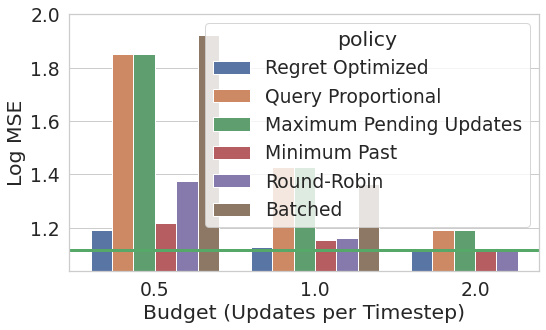

In [51]:
subset = ["random", "total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]
#subset = ["total_error_cold", "min_past"]

plt = plot_factor(60, subset, updates=[0.5, 1, 2])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_1.pdf') 

/tmp/ipykernel_3092022/3053104037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.policy = plot_df.policy.map({


    updates            policy     error  total_updates  ts_factor  max_ts
7       1.0  Regret Optimized  1.128445          12069         60   20018
8       2.0  Regret Optimized  1.119855          19214         60   20018
9       3.0  Regret Optimized  1.117882          22664         60   20018
10      4.0  Regret Optimized  1.117569          24275         60   20018
12      8.0  Regret Optimized  1.116946          25490         60   20018
34      1.0      Minimum Past  1.152806          12069         60   20018
35      2.0      Minimum Past  1.125095          19164         60   20018
36      3.0      Minimum Past  1.118430          22629         60   20018
37      4.0      Minimum Past  1.117484          24269         60   20018
39      8.0      Minimum Past  1.116946          25491         60   20018


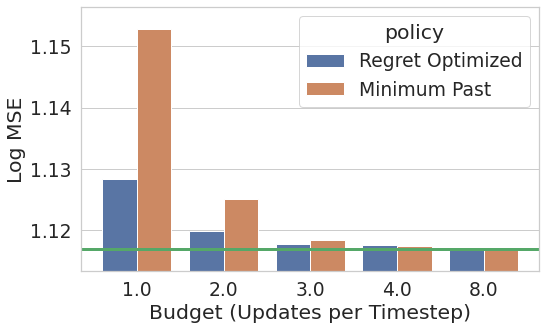

In [52]:
subset = ["total_error_cold", "min_past"]

plot_factor(60, subset, updates=[1, 2, 3, 4, 6, 8])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_2.pdf') 

/tmp/ipykernel_3092022/3053104037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.policy = plot_df.policy.map({


    updates                   policy     error  total_updates  ts_factor  \
4       0.5         Regret Optimized  1.192622           6379         60   
7       1.0         Regret Optimized  1.128445          12069         60   
8       2.0         Regret Optimized  1.119855          19214         60   
9       3.0         Regret Optimized  1.117882          22664         60   
10      4.0         Regret Optimized  1.117569          24275         60   
12      8.0         Regret Optimized  1.116946          25490         60   
13      0.5       Query Proportional  1.852803           6379         60   
16      1.0       Query Proportional  1.427377          12069         60   
17      2.0       Query Proportional  1.192327          19244         60   
18      3.0       Query Proportional  1.138525          22719         60   
19      4.0       Query Proportional  1.123584          24309         60   
21      8.0       Query Proportional  1.116946          25494         60   
22      0.5 

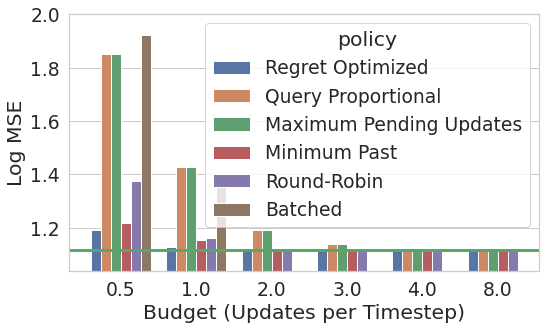

In [53]:
subset = ["total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor(60, subset, updates=[0.5, 1, 2, 3, 4, 6, 8])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_all.pdf') 

/tmp/ipykernel_3092022/1439645019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.policy = plot_df.policy.map({


1.1169459005554807 25497


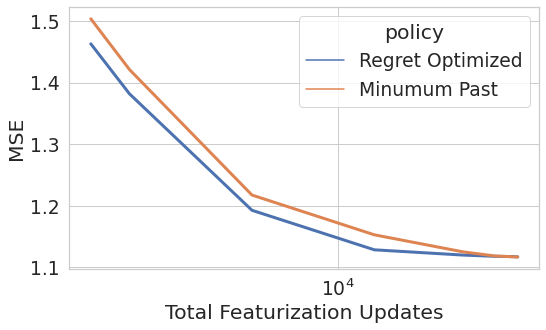

In [54]:
subset = ["total_error_cold", "min_past"] #, "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor_total_updates(60, subset, log=False)
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_line.pdf') 

/tmp/ipykernel_3092022/1439645019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.policy = plot_df.policy.map({


1.1169459005554807 25497


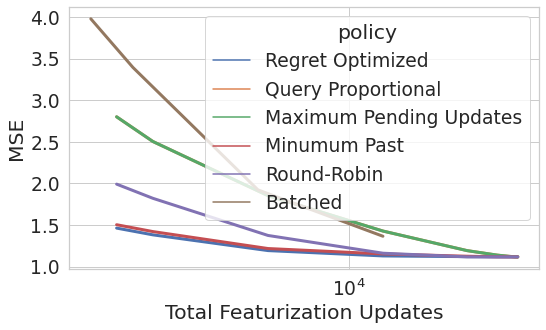

In [55]:
subset = ["total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor_total_updates(60, subset, log=False)
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_line_all.pdf') 

## Plot Rate of Updates vs. Error Improvement 

In [ ]:
window_size = 1 
ts_factor = 60

In [ ]:
stream_df["adj_timestamp"] = stream_df["timestamp"].apply(lambda x: int(x/60))
start_ts = stream_df.adj_timestamp.min()
end_ts = stream_df.adj_timestamp.max()

print(start_ts, end_ts)

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.nunique().to_frame()

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.nunique().to_frame()
time_df = pd.Series(range(start_ts, end_ts, 1)).to_frame("timestamp").merge(count_df, how="left", left_on="timestamp", right_on="adj_timestamp").fillna(0)
user_update_rate_df = time_df.user_id.rolling(window_size).sum()

In [ ]:
user_update_rate_df.plot()

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.count().to_frame()
time_df = pd.Series(range(start_ts, end_ts, 1)).to_frame("timestamp").merge(count_df, how="left", left_on="timestamp", right_on="adj_timestamp").fillna(0)

rating_update_rate_df = pd.DataFrame()
rating_update_rate_df["n"] = time_df.user_id.rolling(window_size).sum()
rating_update_rate_df["timestamp"] = time_df.timestamp.rolling(window_size).max().fillna(0)

In [ ]:
rating_update_rate_df.n.plot()

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
eval_df["error_diff"] = (eval_df["y_pred"] - eval_df["y_true"]).pow(2)
eval_df

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
eval_df["error_diff"] = (eval_df["y_pred"] - eval_df["y_true"]).pow(2)

records = []
for (updates, policy, ts), group in tqdm(eval_df.groupby(["updates", "policy", "timestamp"])): 
    records.append({
        "updates": updates, 
        "policy": policy, 
        "timestamp": ts, 
        "error": group.error_diff.mean()
    })

    
    
print("finished group")
ts_error_df = pd.DataFrame(records)
print(ts_error_df)

In [ ]:
ts_error_df.to_csv(f"{result_dir}/error_time_{ts_factor}.csv")

In [ ]:
error_window_df = ts_error_df.reset_index()

In [ ]:
min_past_df = error_window_df[error_window_df["policy"] == "min_past"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()
max_pending_df = error_window_df[error_window_df["policy"] == "max_pending"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()
optimized_df = error_window_df[error_window_df["policy"] == "total_error_cold"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()

In [ ]:
updates = 0.2

improvement_min_past = min_past_df[min_past_df["updates"] == updates].error - optimized_df[optimized_df["updates"] == updates].error
improvement_max_pending = max_pending_df[max_pending_df["updates"] == updates].error - optimized_df[optimized_df["updates"] == updates].error

In [ ]:
total_counts = []
for ts in tqdm(baseline_df[baseline_df["updates"] == updates].timestamp.tolist()):
    if ts >= 60: 
        total_count = time_df[(time_df["timestamp"] > ts - 60) & (time_df["timestamp"] <= ts)].user_id.unique().sum()
        total_counts.append(total_count)
        
    if len(total_counts) >= 100000:
        break

In [ ]:
improvement

In [ ]:
min_past_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:], "policy": "Minimum Past"})
max_pending_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:], "policy": "Maximum Pending"})

plot_df = pd.concat([min_past_df, max_pending_df])
plot_df

In [ ]:
plt.tight_layout()

g=sns.lmplot(x="update_rate", y="improvement", hue="policy", data=plot_df, order=2, scatter=False, legend=False, height=5, aspect=1.5)

g.set(title="Improvement (Recommendation)", xlabel="Hourly Unique User Ratings",  ylabel="MSE")

g.despine(left=True)
plt.legend(loc='lower center')

results_df.to_csv(f"/data/wooders/ralf-vldb/plots/als_improvements.csv")
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_rate.pdf')

In [ ]:
plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False)

In [ ]:
plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False)

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False, ax=ax, label="Max Pending", x_bins=100)

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_max_pending.pdf')

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False, ax=ax, label="Max Pending", x_bins=100)

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_min_past.pdf')

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=6, scatter=False, ax=ax, label="Minimum Past")

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()

In [ ]:
plot_df = pd.DataFrame({ 
    #"timestamp": rating_update_rate_df.iloc[:1000].timestamp, 
    "update_rate":  rating_update_rate_df.iloc[:100000].n,
    "improvement": improvement.iloc[:100000]
})
plot_df = pd.DataFrame({
    "update_rate": plot_df.groupby("update_rate").groups.keys(), 
    "improvement": plot_df.groupby("update_rate").improvement.mean()
})


sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2)

In [ ]:
sns.scatterplot(x="update_rate", y="improvement", data=plot_df)

In [ ]:
plot_df.groupby("update_rate").groups.keys()

In [ ]:
plot_df = pd.DataFrame({ 
    "timestamp": rating_update_rate_df.iloc[window_size:10000+window_size].timestamp, 
    "update_rate":  rating_update_rate_df.iloc[window_size:10000+window_size].n,
    "improvement": improvement.iloc[0:10000]
})

sns.regplot(x="update_rate", y="improvement", data=plot_df)

In [ ]:
optimized_df[optimized_df["updates"] == 0.2].iloc[:1000].error.mean()

In [ ]:
baseline_df[baseline_df["updates"] == 0.2].iloc[:1000].error.mean()

In [ ]:
error_window_df[(error_window_df["updates"] == 0.2) & (error_window_df["policy"] == "total_error_cold")].error.plot()

In [ ]:
error_window_df

In [ ]:
error_window_df = eval_df.groupby(["policy", "updates"]) \
    .apply(lambda x: x.error_diff.rolling(window_size).sum())#lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)

In [ ]:
error_window_df = error_window_df.reset_index()

In [ ]:
error_window_df

In [ ]:
optimized_window_error = error_window_df[error_window_df["policy"] == "total_error_cold"]
optimized_window_error

In [ ]:
baseline_window_error = error_window_df[error_window_df["policy"] != "total_error_cold"].groupby("updates").apply(lambda x: x.iloc[:, 2:].min()).reset_index()
baseline_window_error

In [ ]:
updates = 0.2

baseline = (baseline_window_error[baseline_window_error["updates"] == updates].iloc[0, 1:]).to_list()
optimized = (optimized_window_error[optimized_window_error["updates"] == updates].iloc[0, 2:]).to_list()

improvement_df = pd.DataFrame({"baseline": baseline, "optimized": optimized})
improvement_df["improvement"] = improvement_df["baseline"] - improvement_df["optimized"]
improvement_df

In [ ]:
improvement_df.improvement.plot()

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
error_dfs = []
improvement_df = []
for t in tqdm(range(start_ts, end_ts, window_size)): 
    eval_t_df = eval_df[(eval_df["timestamp"] >= t) & (eval_df["timestamp"] < t+window_size)]
    
    if len(eval_t_df.index) == 0: continue
    
    group_df = eval_t_df.groupby(["policy", "updates"])
    error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)
    #error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true) if x.y_pred.count() > 0 else 0)

    error_t_df = error_t_df.reset_index(name="error")
    error_t_df["timestamp_idx"] = int(t/window_size)
    error_dfs.append(error_t_df)
    
    
    impr_df = pd.DataFrame()
    impr_df["baseline"] = error_t_df[error_t_df["policy"] != "total_error_cold"].groupby("updates").error.min()
    impr_df["regret_optimized"] = error_t_df[error_t_df["policy"] == "total_error_cold"].groupby("updates").error.min()
    impr_df["timestamp_hr"] = int(t/60)
    impr_df["timestamp"] = t+60
    improvement_df.append(impr_df)
    
    
    

error_df = pd.concat(error_dfs)
improvement_df = pd.concat(improvement_df)
error_df

In [ ]:
u_df = updates_df[(updates_df["ts_factor"] == 60) &(updates_df["policy"] == "round_robin")]

In [ ]:
ts_factor = 60
single_update_df = updates_df[(updates_df["ts_factor"] == 60) &(updates_df["policy"] == "round_robin")]
single_update_df = single_update_df.groupby("time").runtime.count().reset_index()
stream_df["adj_timestamp"] = stream_df["timestamp"].apply(lambda x: int(x/60))
all_update_df = pd.DataFrame()
all_update_df["user_updates"] = stream_df.groupby("adj_timestamp").user_id.nunique()
all_update_df["rating_updates"] = stream_df.groupby("adj_timestamp").user_id.count()
print(all_update_df)
print(single_update_df)

In [ ]:
update_time_df = all_update_df.merge(single_update_df, how="left", left_on="adj_timestamp", right_on="time")
print(update_time_df)
update_time_df = update_time_df[["time", "user_updates", "rating_updates", "runtime"]]
update_time_df.columns = ["timestamp", "user_updates", "rating_updates", "updates"]
update_time_df

In [ ]:

sns.scatterplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000])
sns.scatterplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000])

In [ ]:
plt.tight_layout()
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.regplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000], order=10, label="Number Ratings", x_bins=20, ax=ax)
sns.regplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000], order=10, label="Number Unique Users", x_bins=100, ax=ax)

ax.set(title="Incoming Data Rate per Minute (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Count")
ax.legend()

In [ ]:
plt.tight_layout()
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.scatterplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000], label="Number Ratings", ax=ax)
sns.scatterplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000], label="Number Unique Users", ax=ax)

ax.set(title="Incoming Data Rate per Minute (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Count")
ax.legend()

In [ ]:
df_all

In [ ]:
df_all

In [ ]:
eval_df = df_all[df_all["ts_factor"] == 60]
error_dfs = []
improvement_df = []
for t in tqdm(range(0, 10000, 60)): 
    eval_t_df = eval_df[(eval_df["timestamp"] >= t) & (eval_df["timestamp"] < t+60)]
    
    if len(eval_t_df.index) == 0: continue
    
    group_df = eval_t_df.groupby(["policy", "updates"])
    error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)
    #error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true) if x.y_pred.count() > 0 else 0)

    error_t_df = error_t_df.reset_index(name="error")
    error_t_df["timestamp_hr"] = t/60
    error_dfs.append(error_t_df)
    
    
    impr_df = pd.DataFrame()
    impr_df["baseline"] = error_t_df[error_t_df["policy"] != "total_error_cold"].groupby("updates").error.min()
    impr_df["regret_optimized"] = error_t_df[error_t_df["policy"] == "total_error_cold"].groupby("updates").error.min()
    impr_df["timestamp_hr"] = int(t/60)
    impr_df["timestamp"] = t+60
    improvement_df.append(impr_df)
    
    
    

error_df = pd.concat(error_dfs)
improvement_df = pd.concat(improvement_df)
error_df

In [ ]:
improvement_df = improvement_df.reset_index()

In [ ]:
improvement_df["total_error_change"] = improvement_df["baseline"] - improvement_df["regret_optimized"]

In [ ]:
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)
plot_df = improvement_df
plot_df["total_error_change"] = improvement_df["baseline"] - improvement_df["regret_optimized"]
plot_df["Updates per Hour"] = (plot_df["updates"] * 60).astype(int)
ax = sns.lmplot(x="timestamp", y="total_error_change", hue="Updates per Hour", col="Updates per Hour", col_wrap=2, order=10, data=plot_df)
ax.set(xlabel="Timestep (minutes)",  ylabel="Total Error", ylim=(-30, 60))

ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Hourly Total Error Improvement (Recommendation)")

In [ ]:
df = improvement_df.merge(update_time_df, how="left", on=["timestamp", "updates"])

In [ ]:
df.rating_updates.value_counts()

In [ ]:
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)
ax = sns.regplot(x="timestamp", y="total_error_change", order=10, data=improvement_df)
ax.set(title="Total Error Improvement per Hour (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Total Error")

In [ ]:
improvement_df[improvement_df["total_error_change"] < -100]

In [ ]:
sns.scatterplot(x='timestamp', y='ratings', data=update_time_df[update_time_df["timestamp"] < 10000])
sns.scatterplot(x='timestamp', y='updates', data=update_time_df[update_time_df["timestamp"] < 10000])

In [ ]:
sns.regplot(x='timestamp', y='ratings', data=update_time_df[update_time_df["timestamp"] < 10000], order=10)

In [ ]:
update_time_df["timestamp_hr"] = update_time_df["timestamp"].apply(lambda x: int(x/60))
update_agg_df = update_time_df.groupby("timestamp_hr").ratings.sum().reset_index(name="user_updates")
print(update_agg_df)
sns.lineplot(x='timestamp', y='user_updates', data=update_agg_df[update_agg_df["timestamp_hr"] < 160])

In [ ]:
diff_df = error_df[error_df["policy"] != "total_error_cold"]
diff_df = diff_df.merge(error_df[error_df["policy"] == "total_error_cold"], how="left", on="timestamp", suffixes=('', '_baseline')).reset_index()
diff_df["error_improvement"] = diff_df["error"] - diff_df["error_baseline"]
sns.lineplot(x="timestamp", y="error_improvement", hue="policy", data=diff_df)

In [ ]:
#f, ax = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()
#sns.set_theme(style="whitegrid", font_scale=1.7)
ts_factor_filter = 60

subset = ["total_error_cold", "min_past", "round_robin", "max_pending"]
#subset = ["total_error_cold", "min_past", "max_pending"]

diff_df = error_df[error_df["policy"] != "total_error_cold"]
diff_df = diff_df.merge(error_df[error_df["policy"] == "total_error_cold"], how="left", on="timestamp_hr", suffixes=('', '_baseline')).reset_index()
diff_df["error_improvement"] = diff_df["error"] - diff_df["error_baseline"]

plot_df = diff_df[diff_df.policy.isin(subset)]
plot_df.policy = plot_df.policy.map({
    'total_error_cold': 'Regret Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round-Robin", 
    'max_pending': "Maximum Pending Updates", 
    'last_query': "Read-Optimized", 
    "query_proportional": "Query Proportional",
    "batch": "Batched"
})
#sns.scatterplot(x="timestamp_hr", y="error_improvement", hue="policy", data=plot_df, ax=ax)
g = sns.lmplot(x="timestamp_hr", y="error_improvement", hue="policy", aspect=2, data=plot_df, order=10)
#g.set(ylim=(-1000, 6000))
ax.set(title="Total Error Improvement per Hour (Recommendation)", xlabel="Timestep (hours)",  ylabel="Total Squared Error")

In [ ]:
data_df = error_df[(error_df["policy"] == "total_error_cold") | (error_df["policy"] == "min_past")].reset_index()
data_df["error"] = np.log(data_df["error"])
sns.lineplot(x="timestamp", y="error", hue="policy", data=data_df)

In [ ]:
data_df = error_df[(error_df["policy"] == "total_error_cold") | (error_df["policy"] == "query_proportional")].reset_index()
data_df["error"] = np.log(data_df["error"])
sns.lineplot(x="timestamp", y="error", hue="policy", data=data_df)

In [ ]:
f, ax = plt.subplots(ncols=2, figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.2)
ts_factor = 10 

plot_df = results_df[(results_df["ts_factor"] == 10) & (results_df.policy.isin(["total_error_cold", "min_past", "round_robin", "max_pending", "last_query"]))]
plot_df.policy = plot_df.policy.map({
    'total_error_cold': 'Regret Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round-Robin", 
    'max_pending': "Maximum Pending Updates", 
    'last_query': "Read-Optimized"
})
plot_df = plot_df.dropna()
sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=True, ax=ax[0])

plot_df = plot_df[plot_df.policy.isin(['Minimum Past Updates', 'Regret Optimized'])].reset_index()
print(plot_df)
sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=True, ax=ax[1])

ax[1].set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Updates per Timestep",  ylabel="Log MSE")
ax[1].set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Updates per Timestep",  ylabel="MSE")
#plt.legend(np.flip(plot_df['policy'].unique()), loc='upper right', title="Event Type")

In [ ]:
ax = sns.barplot(x="updates", y="error", hue="policy", data=results_df[results_df["ts_factor"] == 10], log=True)

In [ ]:
updates_df.key.value_counts()

In [ ]:
updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].key.value_counts()

In [ ]:
df_all[(df_all.index > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].user_id.value_counts()

In [ ]:
updates_df

In [ ]:
ts_min = 35000
ts_max = 40000
updates=1

In [ ]:
df_all[(df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].groupby("timestamp").updates.count().plot()


In [ ]:
hist_df = updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].groupby(by=["key", "policy"]).updates.count().reset_index()
hist_df["user_id"] = hist_df["key"]
hist_df["policy"] = hist_df.policy.map({
    'total_error_cold': 'Accuracy Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round Robin", 
    'max_pending': "Maximum Pending"
})
hist_df = hist_df.dropna()
hist_df.user_id.value_counts()

samples_df = df_all[(df_all["timestamp"] > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)]\
    .groupby(by=["user_id", "policy"])\
    .ts_factor.count()\
    .to_frame(name="samples")\
    .reset_index()

In [ ]:
# samples_df = df_all[(df_all.index > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].groupby(by=["user_id", "policy"]).ts_factor.count().to_frame(name="samples")
# ratio_df = pd.DataFrame(samples_df).join(hist_df.set_index(["user_id", "policy"]), on=["user_id", "policy"]).reset_index()
# hist_df = updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].groupby(by=["key", "policy"]).updates.count().reset_index()
# hist_df["user_id"] = hist_df["key"]
# print(ratio_df)
# ratio_df["policy"] = ratio_df.policy.map({
#     'total_error_cold': 'Accuracy Optimized', 
#     'min_past': 'Minimum Past Updates', 
#     'round_robin': "Round Robin", 
#     'max_pending': "Maximum Pending"
# })
# ratio_df = ratio_df.dropna().reset_index()
# ratio_df["ratio"] = ratio_df.apply(lambda x: x["updates"]/x["samples"], axis=1)

# sns.set_theme(style="whitegrid", font_scale=1.5)
# g = sns.histplot(data=ratio_df, x="updates", hue="policy", discrete=False)
# g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number Keys")

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
heat_df

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    yticklabels=["Regret Optimized", "Maximum Pending", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax
)
ax.set_xlabel(f"Most Updated Users (Timestamps {ts_min}-{ts_max})")
ax.set_ylabel(None)
ax.set_title("Number of Featurization Updates")
#plt.legend(fontsize='x-large')
f.savefig('/data/wooders/ralf-vldb/plots/als_heatmap.pdf', dpi=300, bbox_inches = "tight")

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(nrows=2, figsize=(20, 10))
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[0]
)
ax[0].set_xlabel("Most Updated Users")
ax[0].set_ylabel(None)
ax[0].set_title("Featurization Updates")

users = heat_df.columns[1:21]
print(users)
samples = [samples_df[samples_df["user_id"] == u].samples.max() for u in users]
d = pd.DataFrame({"User": range(1, 21, 1), "Raw Data Updates": samples})
print(d)
#d = pd.DataFrame([samples], columns=users, index=["Total Data Points"])
sns.barplot(data=d, x="User", y="Raw Data Updates", ax=ax[1])
#ax[1].set_ylabel(None)
#ax[1].set_title("Raw Data Updates Updates")

In [ ]:
key_df = updates_df[(updates_df["key"] == 2693) & (updates_df["ts_factor"] == 10) & (updates_df["updates"] == 1)]
key_df = key_df.set_index(["time", "policy"]).reset_index()
sns.histplot(key_df, x="time", hue="policy")

In [ ]:
for (i, (key, group)) in enumerate(key_df.groupby("policy")):
    group = group.time.tolist()
    x = group
    y = range(1, len(group) + 1, 1)
    plt.plot(x, y, label=key)
plt.legend()
    

In [ ]:
samples_df[samples_df["user_id"] == 3437]

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(nrows=2, figsize=(20, 10))
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True,
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[0]
)
ax[0].set_xlabel("Most Updated Users")
ax[0].set_ylabel(None)
ax[0].set_title("Featurization Updates")

heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=True).fillna(0)
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[1]
)
ax[1].set_xlabel("Least Updated Users")
ax[1].set_ylabel(None)
ax[1].set_title("Featurization Updates")

In [ ]:
users = heat_df.columns[1:21]
samples = [ratio_df[ratio_df["user_id"] == u].samples.max() for u in users]
d = pd.DataFrame({"User": range(1, 21, 1), "Raw Data Updates": samples})
print(d)
#d = pd.DataFrame([samples], columns=users, index=["Total Data Points"])
sns.barplot(data=d, x="User", y="Raw Data Updates")

In [ ]:
#f, ax = plt.subplots(figsize=(20, 2))

#fig, axs = plt.subplots(2, figsize=(20, 6))
fig, axs = plt.subplots(nrows=3)

fig.suptitle('Vertically stacked subplots')

heat_df = ratio_df.pivot("policy", "user_id", "ratio").fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[0]) #, square=True, annot=True, cbar=False)

heat_df = ratio_df.pivot("policy", "user_id", "updates").sort_values("Accuracy Optimized", axis=1, ascending=False).fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[1], annot=True)

heat_df = ratio_df.pivot("policy", "user_id", "samples").fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[2])


In [ ]:
runtime = 1.0
sns.set(rc={'figure.figsize':(10.7,5.27)})
hist_df = updates_df[updates_df["runtime"] == runtime].groupby(by=["key", "policy"]).size()
hist_df = hist_df / samples_df
print(hist_df.max())
hist_df = hist_df.to_frame(name="updates").reset_index()
print(hist_df.policy.value_counts())
hist_df["policy"] = hist_df.policy.map({'total_error_cold': 'Accuracy Optimized', 'min_past': 'Minimum Past Updates', 'round_robin': "Round Robin"})
hist_df = hist_df.dropna()
print(hist_df.max())

sns.set_theme(style="whitegrid", font_scale=1.5)
g = sns.histplot(data=hist_df, x="updates", hue="policy", log_scale=(False, True), discrete=False, bins=30)
g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number Keys")

In [ ]:
updates_df[(updates_df["policy"] == "total_error") & (updates_df["runtime"] == 1.00)]

# Plot Dataset

In [ ]:
factor = 100

In [ ]:
test_df = pd.read_csv(f'{dataset_dir}/stream.csv')
train_df = pd.read_csv(f'{dataset_dir}/train.csv')
start_ts = test_df.timestamp.min()
past_updates = pickle.load(open(f"{result_dir}/past_updates.pkl", "rb"))
test_df.timestamp = test_df.timestamp.apply(lambda ts: int((ts - start_ts)/factor))

In [ ]:
new_user_df = test_df[test_df.user_id.isin(past_updates.keys())]
old_user_df = test_df[~test_df.user_id.isin(past_updates.keys())]

In [ ]:
old_user_df.groupby(by="timestamp").user_id.nunique().plot(label="old_user").legend()
new_user_df.groupby(by="timestamp").user_id.nunique().plot(label="new_user").legend()

In [ ]:
old_user_df.groupby(by="timestamp").rating.count().rolling(1000).mean().plot(label="old_user")
new_user_df.groupby(by="timestamp").rating.count().rolling(1000).mean().plot(label="new_user").legend()

In [ ]:
test_df.groupby(by="timestamp").count().rolling(window=100).mean().plot()

In [ ]:
train_df.movie_id.value_counts()

In [ ]:
test_df.movie_id.value_counts()

# Results Over Time 

In [ ]:
results[0]

In [ ]:
x0 = 0 #190000#test_df.timestamp.min()
x1 = 200000 #test_df.timestamp.max()

p = "min_past"
u = 1
t = 100
df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
print(df.square_error.mean())
df[(df["timestamp"] < x1) & (df["timestamp"] > x0)].groupby(by="timestamp").square_error.sum().plot(label=p) #rolling(1000).mean().plot(xlim=(x0, x1), label=p)
min_past_df = df

p = "total_error_cold"
df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
print(df.square_error.mean())
df[(df["timestamp"] < x1) & (df["timestamp"] > x0)].groupby(by="timestamp").square_error.sum().plot(label=p).legend() #rolling(1000).mean().plot(xlim=(x0, x1), label=p)
total_error_df = df
#p = "total_error"
#df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
#df["square_error"] = df.y_pred - df.y_true
#df["square_error"] = df["square_error"].apply(lambda x: x*x)
#df[(df["timestamp"] < x1) & (df["timestamp"] > x0) ].groupby(by="timestamp").square_error.sum().rolling(100).mean().plot(label=p).legend() #rolling(1000).mean().plot(xlim=(x0, x1), label=p)


df

In [ ]:
min_past_df

In [ ]:
diff_df = pd.concat([total_error_df, min_past_df]).drop_duplicates(keep=False, subset=["timestamp", "user_id", "movie_id", "square_error"])

In [ ]:
diff_df.groupby(by=["user_id"]).square_error.sum()

In [ ]:
update_table = updates_df[(updates_df["ts_factor"] == t) & (updates_df["updates"] == u)]\
                            .groupby(by=["key", "policy"])\
                            .time.apply(np.array)
                            
update_table

In [ ]:
update_table.loc[1].loc["last_query"]

In [ ]:
df = df_all[(df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.square_error.max()

In [ ]:
df.groupby(by="policy").square_error.mean()

In [ ]:
df[~df.user_id.isin(past_updates.keys())].groupby(by="policy").square_error.mean()

In [ ]:
df[df.user_id.isin(past_updates.keys())].groupby(by="policy").square_error.mean()

In [ ]:
df.groupby(by="user_id").y_true.count()

In [ ]:
for user_id, group in df.groupby(by=["user_id"]):
    #print(group)
    te = group[group["policy"] == "total_error_cold"].square_error.sum()
    mp = group[group["policy"] == "min_past"].square_error.sum()
    if te > mp*1.1: 
        print(user_id, past_updates[user_id], te, mp)
        print("    total_error", update_table.loc[user_id].loc["total_error_cold"].mean(), update_table.loc[user_id].loc["total_error_cold"].shape)
        print("    min_past", update_table.loc[user_id].loc["min_past"].mean(), update_table.loc[user_id].loc["min_past"].shape)

In [ ]:
for user_id, group in diff_df.groupby(by=["user_id"]):
    #print(group)
    te = group[group["policy"] == "total_error_cold"].square_error.sum()
    mp = group[group["policy"] == "min_past"].square_error.sum()
    if te*1.1 < mp: 
        print(user_id, past_updates[user_id] if user_id in past_updates else False, te, mp)
        print("    total_error", update_table.loc[user_id].loc["total_error_cold"].mean(), update_table.loc[user_id].loc["total_error_cold"].shape)
        print("    min_past", update_table.loc[user_id].loc["min_past"].mean(), update_table.loc[user_id].loc["min_past"].shape)

In [ ]:
x0 = test_df.timestamp.min()
x1 = test_df.timestamp.max()

p = "max_pending"
u = 1
t = 100
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
#df.groupby(by="timestamp").square_error.mean().rolling(1000).mean().plot(xlim=(x0, x1))

p = "total_error_cold"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p)


p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()

p = "max_pending"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()

p = "round_robin"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()



df

In [ ]:
p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df[df["y_pred"] > 10]

In [ ]:
x0 = test_df.timestamp.min()
x1 = 1000 #100000


p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().rolling(1).mean().plot(xlim=(x0, x1), label=p).legend()


In [ ]:
p = "total_error_cold"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().rolling(1).mean().plot(xlim=(x0, x1), label=p).legend()
#df[df["square_error"] > 100]

In [ ]:
import pickle

movie_features = pickle.load(open(f"{result_dir}/train_movie_features.pkl", "rb"))
user_features = pickle.load(open(f"{result_dir}/train_user_features.pkl", "rb"))
past_updates = pickle.load(open(f"{result_dir}/past_updates.pkl", "rb"))

In [ ]:
from workloads.recsys.stream_als import  predict_user_movie_rating

In [ ]:
movie_features[481][-1]

In [ ]:
predict_user_movie_rating(user_features[4312], movie_features[481])

In [ ]:
train_df[train_df["movie_id"] == 481]

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().rolling(window=1000).mean().plot()

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().plot(xlim=(x0, x1))

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().rolling(window=1000).mean().plot(xlim=(x0, x1))

In [ ]:
test_df.groupby(by="timestamp").count().plot(xlim=(x0, x1))#.rolling(window=100).mean().plot()

In [ ]:
test_df.groupby(by="timestamp").count().rolling(window=1).mean().plot(xlim=(x0, x1))